In [1]:
import numpy as np
import os, sys
from skimage import io
import matplotlib
from pprint import pprint
from matplotlib import pyplot as plt
from tqdm import tqdm
import neuroglancer

#from PIL import Image
#Image.MAX_IMAGE_PIXELS = None

In [2]:
HOME = os.path.expanduser("~")
PATH = os.path.join(HOME, 'programming/pipeline_utility')
sys.path.append(PATH)
from utilities.sqlcontroller import SqlController
from utilities.file_location import DATA_PATH, ROOT_DIR

Connecting dklab@192.168.1.12:3306


In [34]:
INPUT = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/X/preps/CH2/full_aligned'
files = sorted(os.listdir(INPUT))
midpoint = len(files) // 2
midfilepath = os.path.join(INPUT, files[midpoint])
limit = 1
files = files[midpoint-limit:midpoint+limit]
#files = files[midpoint]
midfile = io.imread(midfilepath)
height, width = midfile.shape
data_type = np.uint8
volume_size = (width, height, len(files))
volume = np.zeros((volume_size), dtype=data_type)

In [10]:
# use skimage
for i, f in enumerate(tqdm(files)):
    infile = os.path.join(INPUT, f)
    img = io.imread(infile)
    img = img.T
    volume[:,:,i] = img.reshape(img.shape[0], img.shape[1], 1)

100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


In [48]:
volume = io.imread(midfilepath)
print(volume.shape)

(11264, 10368)


In [49]:
labels = [[v-8,v-1] for v in range(9,256,8)]
print(labels)

[[1, 8], [9, 16], [17, 24], [25, 32], [33, 40], [41, 48], [49, 56], [57, 64], [65, 72], [73, 80], [81, 88], [89, 96], [97, 104], [105, 112], [113, 120], [121, 128], [129, 136], [137, 144], [145, 152], [153, 160], [161, 168], [169, 176], [177, 184], [185, 192], [193, 200], [201, 208], [209, 216], [217, 224], [225, 232], [233, 240], [241, 248]]


In [54]:
arr = np.copy(volume)
for label in labels:
    mask = (arr >= label[0]) & (arr <= label[1])
    arr[mask] = label[1]
arr[arr > 248] = 255

In [55]:
#volume = volume.reshape(volume.shape[0], volume.shape[1], volume.shape[2])
print('volume shape', arr.shape, arr.dtype, np.unique(arr, return_counts=True))

volume shape (11264, 10368) uint8 (array([  0,   8,  16,  24,  32,  40,  48,  56,  64,  72,  80,  88,  96,
       104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200,
       208, 216, 224, 232, 240, 248, 255], dtype=uint8), array([115834564,     11170,     17206,     26967,     27212,     25001,
           27364,     34485,     35553,     33570,     23958,     20983,
           20117,     20690,     28081,     41943,     49596,     40487,
           52605,     55422,     41881,     32949,     39429,     40009,
           47174,     43149,     32221,     22326,     12814,     14398,
           13662,     12649,      5517]))


Text(0.5, 1.0, ' uint8')

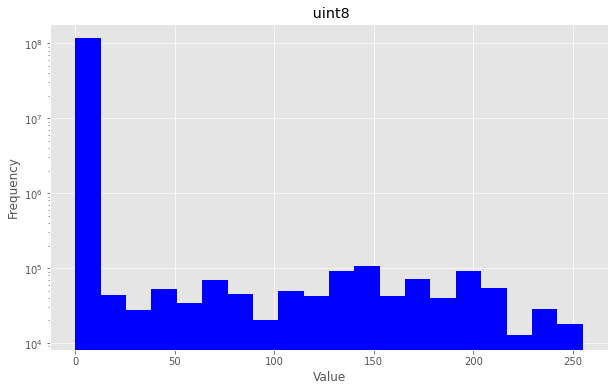

In [56]:
#volume[volume > 0] = 255
#volume[volume < 1] = 0
flat = arr.flatten()
fig = plt.figure()
plt.rcParams['figure.figsize'] = [10, 6]
plt.hist(flat, bins=20, color='b')
plt.style.use('ggplot')
plt.yscale('log')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f' {volume.dtype}')

In [ ]:
arr = np.rot90(volume, axes=(2, 1))
#arr = np.rot90(arr, 3)
#arr = np.flip(arr, axis=1)
    
print(arr.shape)
start = arr.shape[2] // 2
end = arr.shape[2]
nrows = end - start
ncols = 1
plt.style.use('classic')
for i in range(start, end, 10):
    plt.title('Z {}'.format(i))
    plt.imshow(arr[:,:,i], cmap="gray")
    plt.show()
    if i > 40:
        break

In [10]:
dimensions = neuroglancer.CoordinateSpace(
    names=['x', 'y', 'z'],
    units='nm',
    scales=[1000,1000,1000])

viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.dimensions = dimensions
    s.layers['Altas'] = neuroglancer.ImageLayer(
        source=neuroglancer.LocalVolume(
            data=volume,
            dimensions=dimensions,
            voxel_offset=(0, 0, 0),
        ),
        shader="""
#uicontrol float min slider(min=0, max=1, default=0)
#uicontrol float max slider(min=0, max=1, default=1)
#uicontrol float invert slider(min=0, max=1, default=0, step=1)
#uicontrol float brightness slider(min=-1, max=1)
#uicontrol float contrast slider(min=-3, max=3, step=0.01)
void main() {
  float pix_val = toNormalized(getDataValue());
  if(pix_val < min){
  	pix_val = 0.0;
  }
  if(pix_val > max){
    pix_val = 1.0;
  }

  if(invert==1.0){
  	  emitGrayscale((1.0 -(pix_val - brightness)) *
       exp(contrast));
  }
  else{
    emitGrayscale((pix_val + brightness) *
                  exp(contrast));
  }

}

""")
print(viewer)

http://127.0.0.1:40381/v/1bf9c6a2fa5fc57e96d4bb2e2241f9327e27a995/


In [ ]:
print(viewer)